In [1]:
from matplotlib import pyplot as plt
import cv2
import math
import numpy as np

### Helper Functions

In [2]:
def scalarMultiplication(scalar, value):
    s = (1+value)**scalar
    z = (1-value)**scalar
    res = (s-z)/(s+z+EPSILON)
    return res

def phy(value):     
    return 0.5 * np.log((1+value)/((1-value)+EPSILON))

def addition(value1, value2):
    res = (value1+value2)/(1+(value1*value2)+EPSILON)
    return res

def subtract(value1, value2):
    res = (value1-value2)/(1-(value1*value2)+EPSILON)
    return res

def norm(value):
    return abs(phy(value))

def multiplication(value1, value2): 
    return phy(value1) * phy(value2)

def C(m,i):
    return math.factorial(m)/((math.factorial(i)*math.factorial(m-i))+EPSILON)

def mapping(img, source, dest):
    return (dest[1] - dest[0])*((img - source[0]) / (source[1] - source[0])) + dest[0]

![](1.jpg "Title")

In [3]:
def qxi(i, x, w, x0, x1): 
    if (x == w - 1):
        return 0
    return C(m,i)*(np.power((x-x0)/(x1-x), i) * np.power((x1-x)/(x1-x0), m)) 
    
def qyj(j, y, h, y0, y1):
    if (y == h - 1):
        return 0
    return C(n,j)*(np.power((y-y0)/(y1-y), j) * np.power((y1-y)/(y1-y0), n)) 
    
def p(i, j, x, y, w, h):
    x0, x1, y0, y1 = 0, w - 1, 0, h - 1
    return qxi(i, x, w, x0, x1) * qyj(j, y, h, y0, y1)

def membershipMatrix(m, n, w, h):
    ps = np.zeros((m, n, w, h))
    for i in range(m):
        for j in range(n):
            for k in range(w):
                for l in range(h):    
                    ps[i, j, k, l] = p(i, j, k, l, w, h)
    return ps

![](2.jpg)

In [4]:
def windowWeights(m, n, w, h, gamma, ps):
    ws = np.zeros((m, n, w, h))
    for i in range(m):
        for j in range(n):
            psPowerGamma = np.power(ps[i, j], gamma)
            for k in range(w):
                for l in range(h):    
                    ws[i, j, k, l] = psPowerGamma[k, l] / (np.sum(ps[:, :, k, l])+EPSILON)
    return ws

![](3.jpg)

In [5]:
def windowCard(w):
    return np.sum(w)


def mean(w, i, j, encoded_photo, height, width):
    mean = 0
    for k in range(height):
        for l in range(width):
            mean = addition(mean, scalarMultiplication(w[i, j, l, k], encoded_photo[k, l]))
    mean /= windowCard(w[i, j])
    return mean

def variance(w, i, j, encoded_photo, means, height, width):
    variance = 0
    for k in range(height):
        for l in range(width):
            variance += w[i, j, l, k] * np.power(norm(subtract(encoded_photo[k, l], means[i, j])), 2)
    variance /= windowCard(w[i, j])
    return variance

def lamda(w, i, j, variances):
    return np.sqrt(IDEAL_VARIANCE) / (np.sqrt(variances[i, j])+EPSILON)

def windowParameters(ws, layer, height, width):
    means = np.zeros((m, n))
    variances = np.zeros((m, n))
    lamdas = np.zeros((m, n))
    taos = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            means[i, j] = mean(ws, i, j, layer, height, width)
            variances[i, j] = variance(ws, i, j, layer, means, height, width)
            lamdas[i, j] = lamda(ws, i, j, variances)
    taos = means.copy()
    return means, variances, lamdas, taos

![](4.jpg)
![](5.jpg)

In [6]:
def windowEnhacement(w, i, j, photo, lamdas, taos):
    return scalarMultiplication(lamdas[i, j], subtract(photo, taos[i, j]))

def imageEnhacement(w, photo, lamdas, taos):
    newImage = np.zeros(photo.shape)
    width = photo.shape[1]
    height = photo.shape[0]
    
    for i in range(m):
        for j in range(n):
            win = windowEnhacement(i, j, photo, lamdas, taos)
            w1 = w[i, j].T.copy()

            for k in range(width):
                for l in range(height):
                    newImage[l, k] = addition(newImage[l, k], scalarMultiplication(w1[l, k], win[l, k]))
    
    return newImage

In [15]:
class ImageType:
    GREY = 1
    COLORED = 0
    
def enhanceLayer(ws, layer, lamdas, taos):
    enhancedImage = imageEnhacement(ws, layer, lamdas, taos)
        
    resLayer = mapping(enhancedImage, (-1, 1), (0, 255))
    resLayer = np.round(resLayer)
    resLayer = resLayer.astype(np.uint8)
    
    return resLayer
    
def enhance(img, type):
    WIDTH = img.shape[1]
    HEIGHT = img.shape[0]   
    
    if type == ImageType.GREY:
        greyLayer = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #####
        nGrey = mapping(greyLayer, (0, 255), (-1, 1))  
        
        ps = membershipMatrix(m, n, WIDTH, HEIGHT)
        ws = windowWeights(m, n, WIDTH, HEIGHT, GAMMA, ps) 
    
        means, variances, lamdas, taos = windowParameters(ws, nGrey, HEIGHT, WIDTH)
    
        resImage = enhanceLayer(ws, nGrey, lamdas, taos)
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap = 'gray')
        plt.subplot(1, 2, 2)
        plt.imshow(resImage, cmap = 'gray')
        plt.show()
        
    else:
        B, G, R = cv2.split(img)
    
        nB, nG, nR = mapping(B, (0, 255), (-1, 1)), mapping(G, (0, 255), (-1, 1)), mapping(R, (0, 255), (-1, 1))
        nRGB = scalarMultiplication(1/3, addition(addition(nB, nG), nR))

        ps = membershipMatrix(m, n, WIDTH, HEIGHT)
        ws = windowWeights(m, n, WIDTH, HEIGHT, GAMMA, ps)
        
        means, variances, lamdas, taos = windowParameters(ws, nRGB, HEIGHT, WIDTH)

        resR = enhanceLayer(ws, nR, lamdas, taos)
        resG = enhanceLayer(ws, nG, lamdas, taos)
        resB = enhanceLayer(ws, nB, lamdas, taos)

        resImg = cv2.merge([resB, resG, resR])
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(resImg, cv2.COLOR_BGR2RGB))
        plt.show()


### Constants

In [16]:
EPSILON = 0.00001
GAMMA = 1 # Control Brightness
IDEAL_VARIANCE = 0.35 # Control Contrast
# number of windows = n * m = 4
n = 2
m = 2 

### Tests

(2, 2, 200, 249) (2, 2, 200, 249)


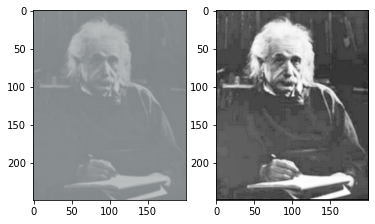

In [17]:
img = cv2.imread('images/enishtein.PNG')
enhance(img, ImageType.GREY)

[0.8, 0.1, 0.1]

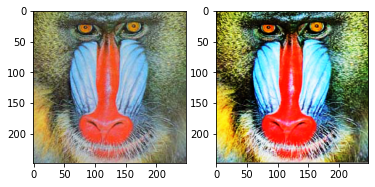

In [11]:
IDEAL_VARIANCE = 1 
img = cv2.imread('images/monkey.PNG')
enhance(img, ImageType.COLORED)